# Background

## Fractional gates on IBM QPUs
Fractional gates are parameterized quantum gates that enable direct execution of arbitrary-angle rotations, eliminating the need to decompose them into multiple basis gates. By leveraging the native interatcions b/w physical qubits, users can implement certain unitaries more efficiently on hardware.  
IBM Heron suppports the following fractional gates:
* $R_ZZ(\theta) \; for \; 0 < \theta < \pi/2$
* $R_X(\theta) \; for \; any \; real \; value \; \theta$
These can significantly reduce both the depth and duration of quantum circuits

## Limitations  
Fractional gates are currently an experimental feature and come with a few constraints:  
* $R_ZZ$ is limited to angles in the range $0<\theta<\pi/2$  
* not supported for dynamic circuits, Pauli twirling, probablisctic error cancellation, and zero-noise extrapolation  

Fractional gates require a different workflow compared to the standard approach. This tutorial explains how to work with fractional gates through a practical application,

# Overview  
There are two approaches to ensure this condition is met. This tutorial focuese on adn recommends the second approach

## 1. Generate parameter satisfying the RZZ angle constraint

```
pm = generate_preset_pass_manager(backend=backend, ...)
t_circuit = pm.run(circuit)
t_observable = observable.apply_layout(t_circuit.layout)
sampler.run([(t_circuit, parameter_values)])
estimator.run([(t_circuit, t_observable, parameter_values)])
```

## 2. Assign parameter values to circuits before transpilation  
The ```qiskit-ibm-runtime``` package provides a specialized transpiler pass called ```FoldRzzAngle```. This pass transforms quantum circuits so taht all RZZ angles comply with the RZZ angle constraint. If you provide the backend to ```generate_preset_passs_manager``` or ```transpile```, Qiskit automatically applies ```FoldRzzAngle``` to the quantum circuits,  
```
pm = generate_preset_pass_manager(backend=backend, ...)
b_circuit = circuit.assign_parameters(parameter_values)
t_circuit = pm.run(b_circuit)
t_observable = observable.apply_layout(t_circuit.layout)
sampler.run([(t_circuit,)])
estimator.run([(t_circuit, t_observable)])
```  
It incures a highter computational cost than first approach.

## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import unitary_overlap
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

## Enable fracional gates and check basis gates

In [4]:
service = QiskitRuntimeService()
backend_name = "ibm_fez"
backend_c = service.backend(backend_name)  # w/o fractional gates
backend_f = service.backend(
    backend_name, use_fractional_gates=True
)  # w/ fractional gates
print(f"Backend: {backend_name}")
print(f"No fractional gates: {backend_c.basis_gates}")
print(f"With fractional gates: {backend_f.basis_gates}")
if "rzz" not in backend_f.basis_gates:
    print(f"Backend {backend_name} does not support fractional gates")

Backend: ibm_fez
No fractional gates: ['cz', 'id', 'rz', 'sx', 'x']
With fractional gates: ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']


# Workflow with fractional gates

## Setup 1: Map classical inputs to quantum problem  
We begin by constructing a quantum circuit to compute indiviual entries of the kernel matrix. The kernel funciton takes vectors in the feature-mapped space and returns their inner product as an entry of the kernel matrix: $K(x,y) = \langle\Phi(x)|\Phi(y)\rangle$, where $|\Phi(x)\rangle$ represents the feature-mapped quantum state  
We manually construct ZZ feature map circuit using RZZ gates.   
Next, we compute the kernel function for identical inputs - for example, $K(x,x)=1$ on noisy quantum computers, this value may be less than 1 due to noise. A result coser to 1 indicates lower noise in the execution. Here, we refer to this value as the *fidelity* defined as $fidelity = K(x,x)$

In [5]:
optimization_level = 2
shots = 2000
reps = 3
rng = np.random.default_rng(seed= 123)

In [14]:
def my_zz_feature_map(num_qubits: int, reps: int = 1) -> QuantumCircuit:
    x = ParameterVector("x", num_qubits * reps)
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    for k in range(reps):
        K = k * num_qubits
        for i in range(num_qubits):
            qc.rz(x[i + K], i)
        pairs = [(i, i + 1) for i in range(num_qubits - 1)]
        for i, j in pairs[0::2] + pairs[1::2]:
            qc.rzz((np.pi - x[i + K]) * (np.pi - x[j + K]), i, j)
    return qc
 
 
def quantum_kernel(num_qubits: int, reps: int = 1) -> QuantumCircuit:
    qc = my_zz_feature_map(num_qubits, reps=reps)
    inner_product = unitary_overlap(qc, qc, "x", "y", insert_barrier=True)
    inner_product.measure_all()
    return inner_product
 
 
def random_parameters(inner_product: QuantumCircuit) -> np.ndarray:
    return np.tile(rng.random(inner_product.num_parameters // 2), 2)
 
 
def fidelity(result) -> float:
    ba = result.data.meas
    return ba.get_int_counts().get(0, 0) / ba.num_shots

In [15]:
qubits = list(range(4, 44, 4))
circuits = [quantum_kernel(i, reps=reps) for i in qubits]
params = [random_parameters(circ) for circ in circuits]

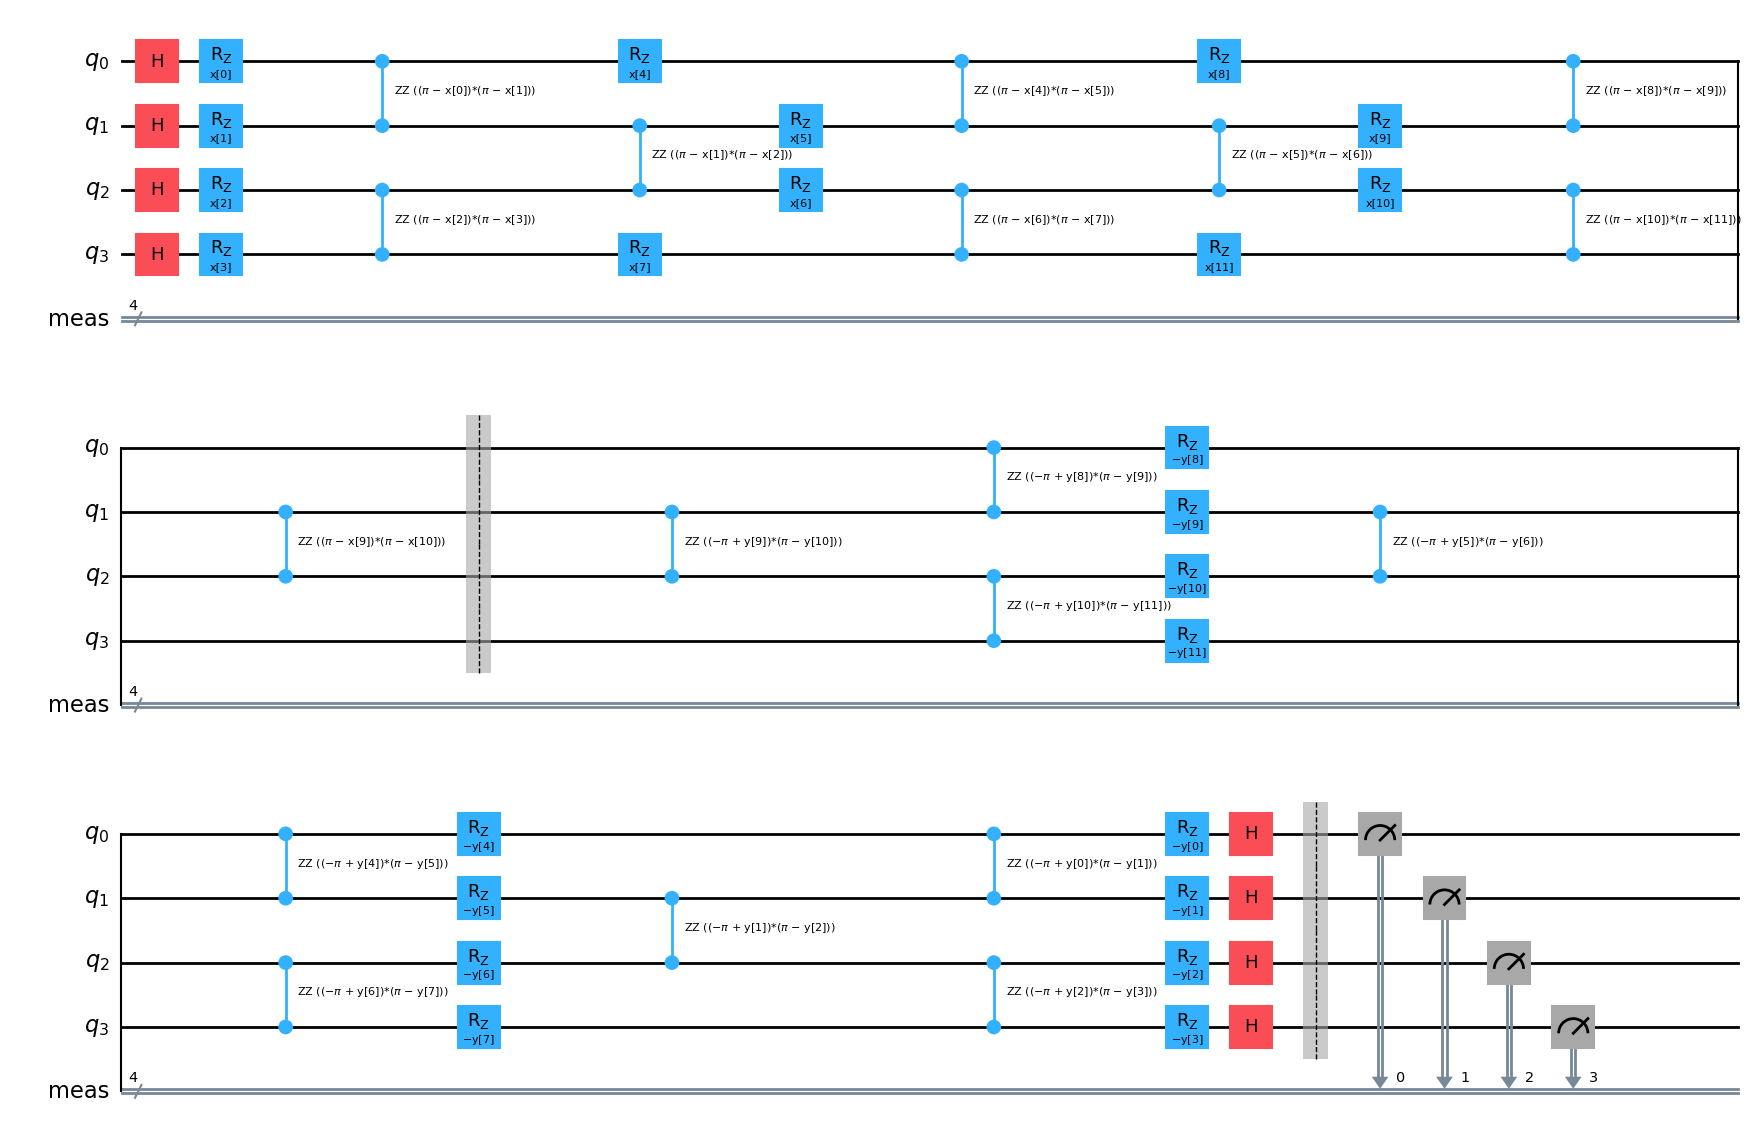

In [30]:
circuits[0].draw("mpl")

In the standard Qiskit patterns workflow, parameter values are typically passed to the Sampler or Estimator primitive as part of a PUB. However, when using a backend that supports fractional gates, these parameter values must be explicitly assigned to the quantum circuit prior to transpilation

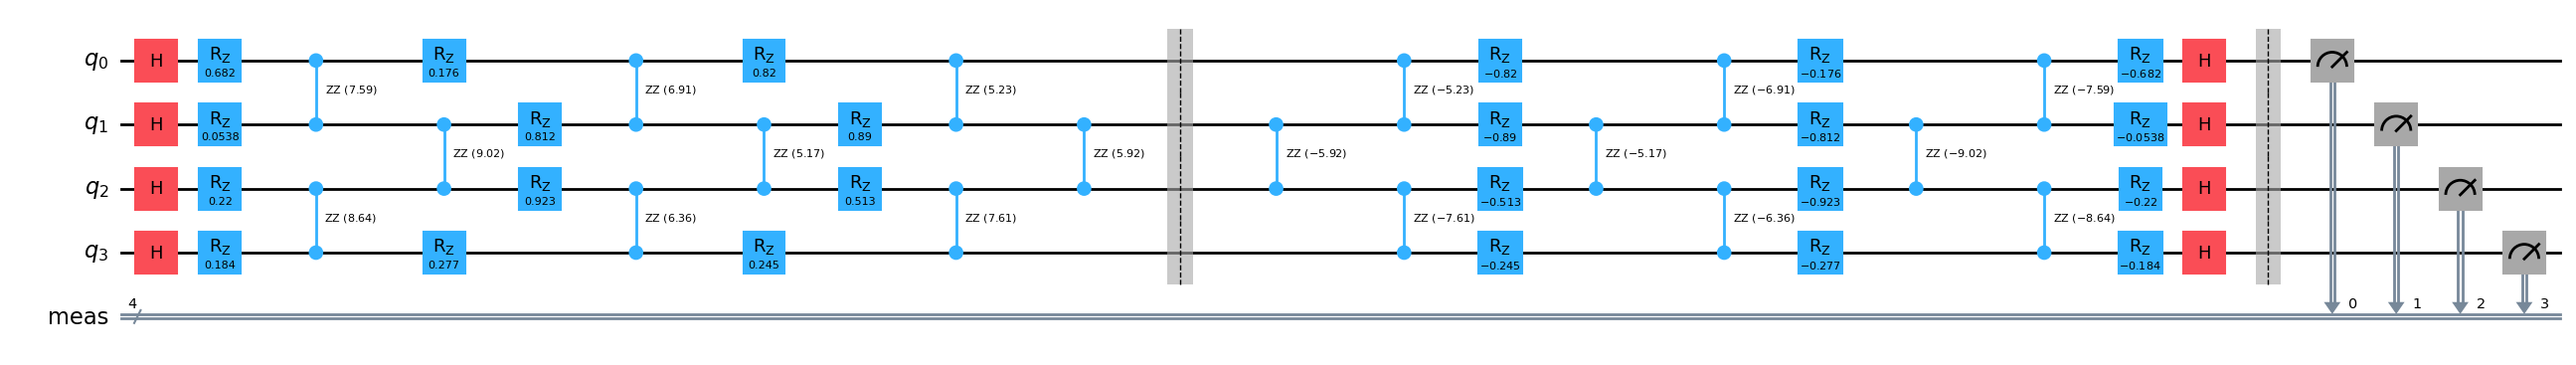

In [24]:
b_qc = [
    circ.assign_parameters(param) for circ, param in zip(circuits, params)
]
b_qc[0].draw("mpl", fold=-1)

## Step 2: Optimize problem for quantum hardware execution  
By providing a backend that supports fractional gates to ```generate_preset_pass_manager```, a specialized pass called ```FoldRzzAngle``` is automatically included. This pass modeifies the circuit to comply with the RZZ angle constraints. As a resul, RZZ gates with negative values in the previous figures are transformed into positive values , and some additional X gates are added

In [31]:
backend_f = service.backend(name=backend_name, use_fractional_gates=True)
# pm_f includes `FoldRzzAngle` pass
pm_f = generate_preset_pass_manager(
    optimization_level=optimization_level, backend=backend_f
)

OrderedDict([('rz', 35), ('rzz', 18), ('x', 13), ('rx', 9), ('measure', 4), ('barrier', 2)])


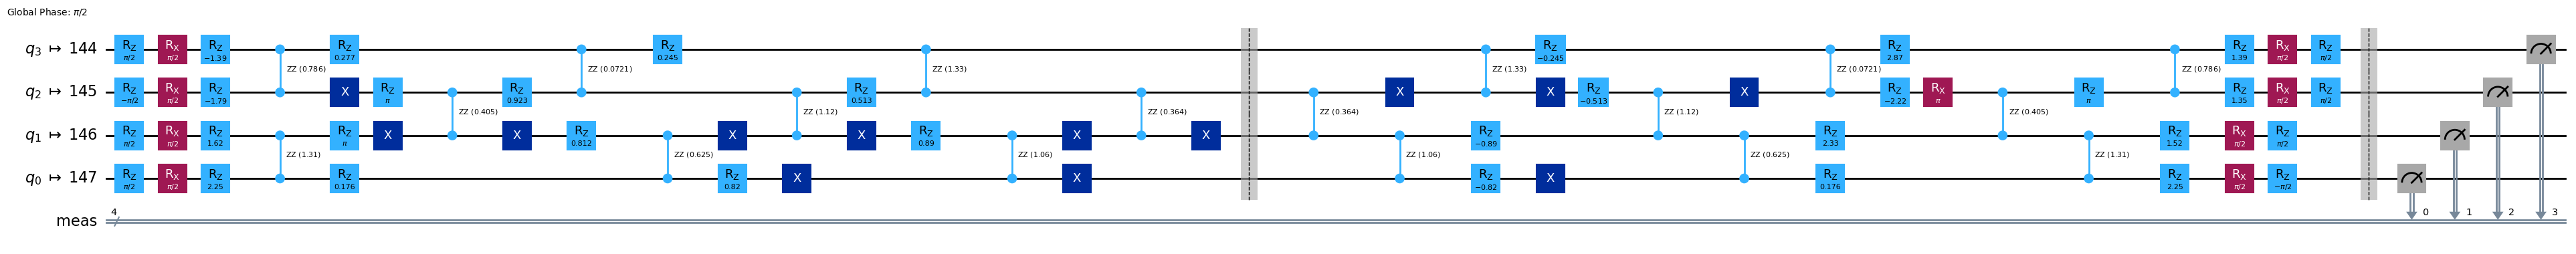

In [ ]:
t_qc_f = pm_f.run(b_qc) # params are already assigned
print(t_qc_f[0].count_ops())
t_qc_f[0].draw("mpl", fold=-1)

To assess the impact of fractional gates, we evaluate the number of non-local gates (CZ and RZZ for this backend), along with circuit depths and durations, and compare these metrics to those from a standard workflow later.

In [37]:
nnl_f = [qc.num_nonlocal_gates() for qc in t_qc_f]
depth_f = [qc.depth() for qc in t_qc_f]
duration_f = [
    qc.estimate_duration(backend_f.target, unit="u") for qc in t_qc_f
]

print(qubits)
print(nnl_f)
print(depth_f)
print(duration_f)

[4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
[18, 42, 66, 90, 114, 138, 162, 186, 210, 234]
[35, 36, 40, 39, 39, 38, 38, 38, 38, 39]
[2.7440000000000007, 2.712, 2.712, 2.712, 2.712, 2.712, 2.88, 2.928, 2.712, 2.952]


## Step 3: Execute using Qiskit primitives

In [38]:
sampler_f = SamplerV2(mode=backend_f)
sampler_f.options.dynamical_decoupling.enable = True
sampler_f.options.dynamical_decoupling.sequence_type = "XY4"
sampler_f.options.dynamical_decoupling.skip_reset_qubits = True

In [39]:
job = sampler_f.run(t_qc_f, shots=shots)
print(job.job_id())

d4d8p3cnntuc73aavmh0


## Step 4: Post-process and return result in desired classical format  
You can obtain the kernel function value $K(x,x)$ by measuring the probability of the all-zero bitstring in the output

In [ ]:
result = job.result()
fidelity_f = [fidelity(result=res) for res in result]
print(fidelity_f)
usage_f = job.usage() # return job usage in seconds

[0.898, 0.817, 0.5755, 0.508, 0.418, 0.321, 0.199, 0.161, 0.2155, 0.122]


# Comparison of workflow and circuit w/o fractional gates  
We present the standard Qiskit patterns workflow using a backend that does not support fractional gates

OrderedDict([('rz', 130), ('sx', 80), ('cz', 36), ('measure', 4), ('barrier', 2)])


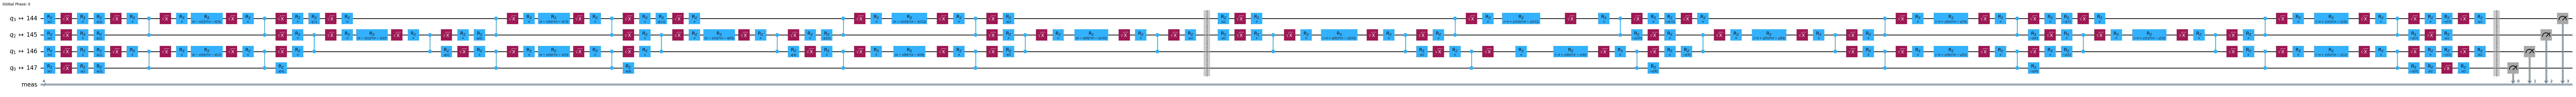

In [ ]:
# step 1: map classical inputs to quantum problem
# `circuits` and `params` from the previous section are reused here

# step 2: optimize circuits
backend_c = service.backend(backend_name)  # w/o fractional gates
pm_c = generate_preset_pass_manager(
    optimization_level=optimization_level, backend=backend_c
)

t_qc_c = pm_c.run(circuits)
print(t_qc_c[0].count_ops())
t_qc_c[0].draw("mpl", fold=-1)

In [ ]:
nnl_c = [qc.num_nonlocal_gates() for qc in t_qc_c]
depth_c = [qc.depth() for qc in t_qc_c]
duration_c = [
    qc.estimate_duration(backend_c.target, unit="u") for qc in t_qc_c
]
print(qubits)
print(nnl_c)
print(depth_c)
print(duration_c)

[4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
[36, 84, 132, 180, 228, 276, 324, 372, 420, 468]
[126, 126, 126, 126, 126, 126, 126, 126, 126, 126]
[4.3919999999999995, 4.392, 4.152, 4.152, 4.152, 4.152, 4.152, 4.152, 4.152, 4.152]


In [46]:
# step 3: execute
sampler_c = SamplerV2(backend_c)
sampler_c.options.dynamical_decoupling.enable = True
sampler_c.options.dynamical_decoupling.sequence_type = "XY4"
sampler_c.options.dynamical_decoupling.skip_reset_qubits = True

In [49]:
job = sampler_c.run(pubs=zip(t_qc_c, params), shots=shots)
print(job.job_id())

d4d8s41eg65s738l7qm0


In [50]:
# step 4: post-processing
# job = service.job("d1obp8j3rr0s73bg4810")
result = job.result()
fidelity_c = [fidelity(res) for res in result]
print(fidelity_c)
usage_c = job.usage()

[0.7935, 0.4705, 0.2285, 0.1745, 0.108, 0.0315, 0.0185, 0.0065, 0.0015, 0.001]


## Comparison of depths and fidelities

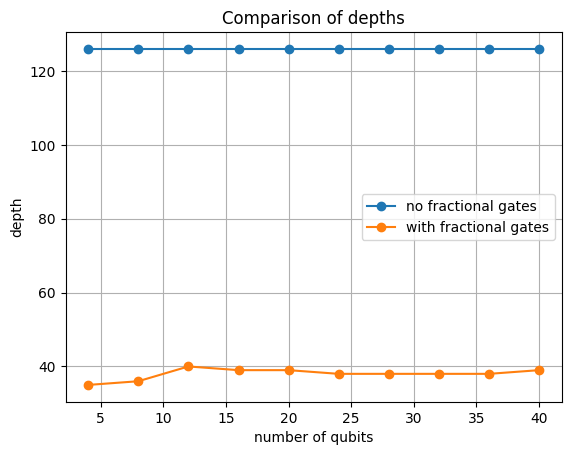

In [51]:
plt.plot(qubits, depth_c, "-o", label="no fractional gates")
plt.plot(qubits, depth_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("depth")
plt.title("Comparison of depths")
plt.grid()
plt.legend()

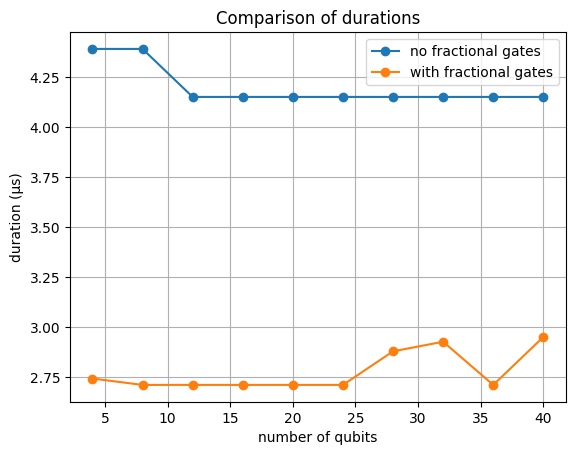

In [53]:
plt.plot(qubits, duration_c, "-o", label="no fractional gates")
plt.plot(qubits, duration_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("duration (µs)")
plt.title("Comparison of durations")
plt.grid()
plt.legend()

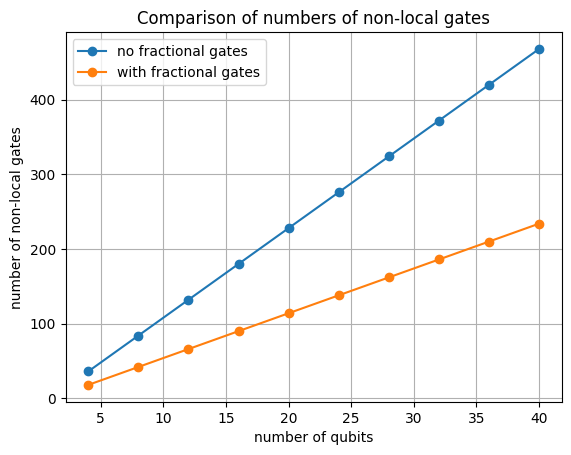

In [54]:
plt.plot(qubits, nnl_c, "-o", label="no fractional gates")
plt.plot(qubits, nnl_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("number of non-local gates")
plt.title("Comparison of numbers of non-local gates")
plt.grid()
plt.legend()

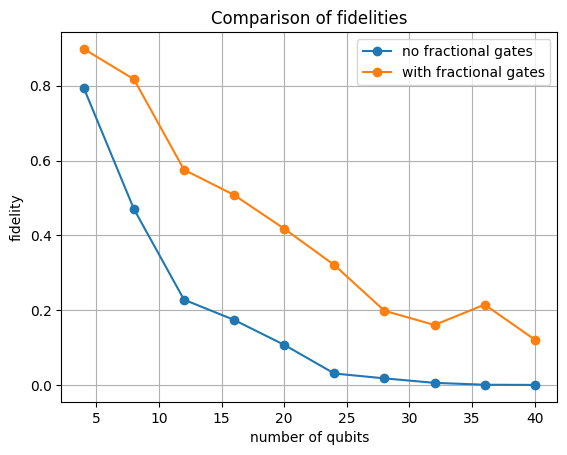

In [55]:
plt.plot(qubits, fidelity_c, "-o", label="no fractional gates")
plt.plot(qubits, fidelity_f, "-o", label="with fractional gates")
plt.xlabel("number of qubits")
plt.ylabel("fidelity")
plt.title("Comparison of fidelities")
plt.grid()
plt.legend()

In [56]:
print(f"no fractional gates: {usage_c} seconds")
print(f"fractional gates: {usage_f} seconds")

no fractional gates: 7 seconds
fractional gates: 7 seconds
